In [ ]:
# FROM https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

In [32]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
import re

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [34]:
path = 'camoes.txt'
text = open(path, encoding="utf8").read().lower()
text = re.sub(r'[^A-Za-z. ]', '', text)
print('corpus length:', len(text))

corpus length: 306701


In [35]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 28


In [36]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 102221


In [37]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [40]:
sentences[100]

'.orgtitle os lusadasauthor lus vaz de ca'

In [41]:
next_chars[100]

'm'

In [42]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False])

In [43]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False])

In [44]:
X.shape

(102221, 40, 28)

In [45]:
y.shape

(102221, 28)

In [46]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [47]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=3, shuffle=True).history

Train on 97109 samples, validate on 5112 samples
Epoch 1/3
97109/97109 [==============================] - 52s 534us/step - loss: 2.1528 - acc: 0.3296 - val_loss: 3.3349 - val_acc: 0.1594
Epoch 2/3
97109/97109 [==============================] - 51s 524us/step - loss: 1.8861 - acc: 0.4141 - val_loss: 3.2689 - val_acc: 0.1952
Epoch 3/3
97109/97109 [==============================] - 51s 527us/step - loss: 1.7647 - acc: 0.4533 - val_loss: 3.2247 - val_acc: 0.2044


In [48]:
# SAVE
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [49]:
# LOAD
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

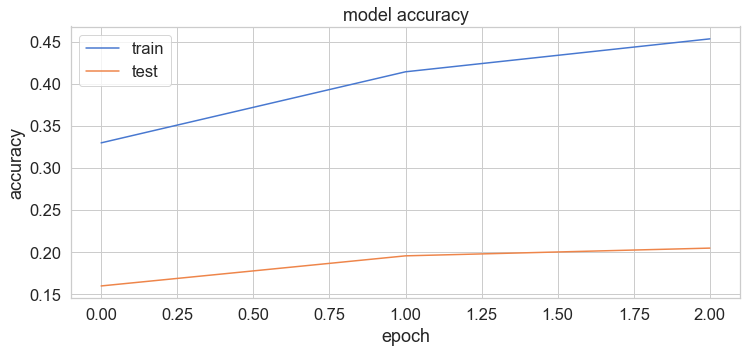

In [50]:
# Evaluation
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

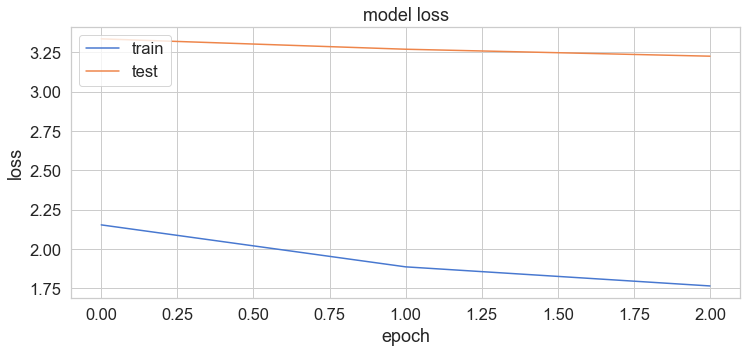

In [51]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [52]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [53]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [54]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [55]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [56]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [59]:
quotes = [
    "hoje e o dia"
]

In [60]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

hoje e o dia
['  ', 'm ', 's ', 'a ', 'n ']

